**Name** : Vruditkumar Patel

Module 4 Assignment

EAI 6010.

# **Introduction**

The given assignment is intended to refer a tutorial and replace a dataset by my choice. Here I am going to make a model for imaage caption generation. My dataset will be **Flikr8k**. It has around 8000 images with captions.

This assignment is combination of **computer vision** and **natural language processing**. For the transformer, **Encoder** will be **Vision Transformer** and **Decoder** will be **GPT-2**. **Seq2SeqTrainer** is used from **hugging face** for fine tuning the model.

First I will import all necessary libraries.

In [ ]:
!pip install datasets
!pip install transformers==4.17

In [ ]:
from IPython.display import clear_output
!pip install rouge_score -q
!pip install deep-phonemizer -q
clear_output()

In [ ]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('I will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, Let me go with CPU.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
I will use the GPU: Tesla T4


Here, I am going to create a class named "config" which will store all the  variables which will be used later on. This is good idea to write a code in professional way.

In [ ]:
os.environ["WANDB_DISABLED"] = "true"
class config :
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

The below function named "build_inputs_with_special_tokens" will create a special tokens while tokenize the captions.

In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

Here I am defining the rouge function.

**What is rouge matrix?**

ROUGE is an evaluation metric commonly used in natural language processing (NLP) and specifically in the context of text summarization and machine translation. ROUGE stands for "Recall-Oriented Understudy for Gisting Evaluation." It is designed to measure the quality of summaries by comparing them to reference summaries

In [ ]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

<ipython-input-7-15d4c46f5e43>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


**Now** as I need to generate the Captions, It will require NLP for training purpose. Thus below is the function for feature extracttor. Here, I will use ViTFeatureExtractor for tokenizing the captions.

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Here, I will define the transformer for resizing the image. It will also normalize and convert image into tensor.

Apart from it, As Flickr8k has around 8k images, My laptop is not capable enough to handle such a large dataset. Even Google colab also provide GPU access for few hours. After that we can not use GPUs. Thus, I decided to reduce the size of the dataset. Here I am using df_sample function and getting only 22% of original dataset.

In [ ]:
custom_transform = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5
        )
   ]
)


df=  pd.read_csv("/content/drive/MyDrive/Module 4/Assignment/Flickr/captions.txt")
df_sampled = df.sample(frac=0.22, random_state=config.SEED)
train_df, val_df = train_test_split(df_sampled, test_size=0.1, random_state=config.SEED)

df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
print(len(train_df), len(val_df))

8010 890


Below is the function for reading the image from the directory. In addition it will transform image using above defined tranformer function. Further transformed image will pass through feature extraction to extract the pixel value from the image.
Captions will be loaded and tokenized.It will then go for padding for maximum lenght. After all, images and tokenized captions are returned.


In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = custom_transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding

In [ ]:
train_dataset = ImgDataset(train_df, root_dir = "/content/drive/MyDrive/Module 4/Assignment/Flickr/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/content/drive/MyDrive/Module 4/Assignment/Flickr/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

In [ ]:
len(train_dataset)

8010

Below is a vision tranformer. The Vision Transformer, or ViT, is a way of sorting images into different categories. It uses a structure similar to a Transformer on parts of the image called patches. The image is divided into patches, and each patch is turned into a sequence of numbers. These sequences, along with their positions, go through a Transformer-like process. To decide on the category, a common method is used, which involves adding a special "classification token" to the sequence.

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.3.crossattention.bias', 'h.11.crossattention.bias', 'h.0.ln_cross_attn.weight', 'h.2.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.2.crossattention.c_proj.weight', 'h.7.crossattention.bias', 'h.9.crossattention.c_proj.weight', 'h.7.crossattention.c_attn.weight', 'h.4.crossattention.masked_bias', 'h.9.crossattention.q_attn.weight', 'h.9.crossattention.c_proj.bias', 'h.10.crossattention.q_attn.weight', 'h.10.crossattention.bias', 'h.5.crossattention.c_proj.bias', 'h.5.crossattention.bias', 'h.3.ln_cross_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.3.crossattention.masked_bias', 'h.8.crossattention.c_proj.weight', 'h.11.crossattention.c_proj.weight', 'h.2.crossattention.q_attn.weight', 'h.3.crossattention.c_attn.weight', 'h.0.crossattention.masked_bias', 'h.5.crossattention.masked_bias', 'h.0.crossattention.bias', 'h.6.crossattention.bias', 'h.

Now for the NLP, **GPT-2** is a type of transformer model that has been trained on a large amount of English text in a special way. It learns by predicting the next word in a sequence of words. The input is a series of words, and the goal is to predict the same series with each word shifted one position to the right. The model uses a mask to only consider information from earlier words, not ones that come later.

This process helps the model understand and represent the structure of the English language. The knowledge it gains can be useful for our task.

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# making sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# setting beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

From the below cell, training will be perfromed. Here Seq2SeqTrainer is used from hugging face.

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# instantiating trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8010
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3006


***** Running Evaluation *****
  Num examples = 890
  Batch size = 8
***** Running Evaluation *****
  Num examples = 890
  Batch size = 8
Saving model checkpoint to VIT_large_gpt2/checkpoint-2048
Configuration saved in VIT_large_gpt2/checkpoint-2048/config.json
Model weights saved in VIT_large_gpt2/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-2048/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 890
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3006, training_loss=2.7808143478667664, metrics={'train_runtime': 6205.0937, 'train_samples_per_second': 3.873, 'train_steps_per_second': 0.484, 'total_flos': 4.336547303616676e+18, 'train_loss': 2.7808143478667664, 'epoch': 3.0})

The model learned from a set of 8010 examples over three training sessions. I checked how well it did using some measures, like Rouge2 Precision, Recall, and Fmeasure, which tell us how good the model is at making image captions compared to correct captions. These measures improved as the model practiced more, showing it got better over time. The training loss, a measure of how well the model learned, went down, reaching a final value of 2.635900. A lower training loss usually means the model understood the training data well. The validation loss, which helps us to see how well the model works on new, unseen data, also decreased from 2.8547 to 2.6257 between the first and third training sessions. This suggests the model got better at making accurate captions not just for the examples it saw during training but also for new ones. In conclusion, the model learned and improved during training, making it good at creating high-quality image captions.

In [ ]:
trainer.save_model('VIT_large_gpt2')

Saving model checkpoint to VIT_large_gpt2
Configuration saved in VIT_large_gpt2/config.json
Model weights saved in VIT_large_gpt2/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/preprocessor_config.json


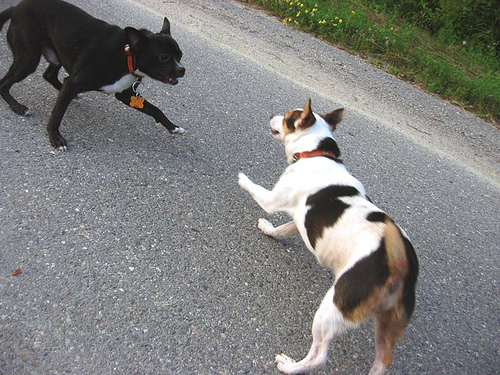

In [ ]:
img =  Image.open("/content/drive/MyDrive/Module 4/Assignment/Flickr/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print(generated_caption[:85])

<|endoftext|>A black and white dog is running in the snow... a black and brown dog is


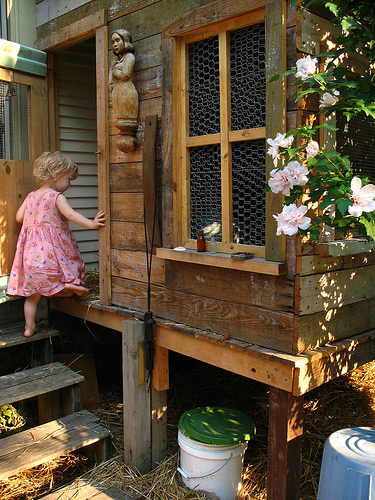

In [ ]:
img =  Image.open("/content/drive/MyDrive/Module 4/Assignment/Flickr/Images/1000268201_693b08cb0e.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print(generated_caption[:120])

<|endoftext|>A girl in a pink dress is sitting on a stone wall. A boy in a white dress is standing in the doorway. A gir


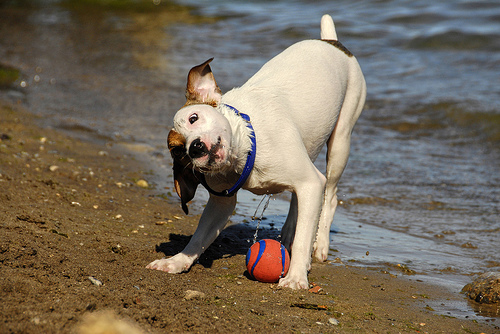

In [ ]:
img =  Image.open("/content/drive/MyDrive/Module 4/Assignment/Flickr/Images/1012212859_01547e3f17.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print(generated_caption[:120])

<|endoftext|>A brown and white dog is running through the water... the water is blue and white. the dog is standing in t


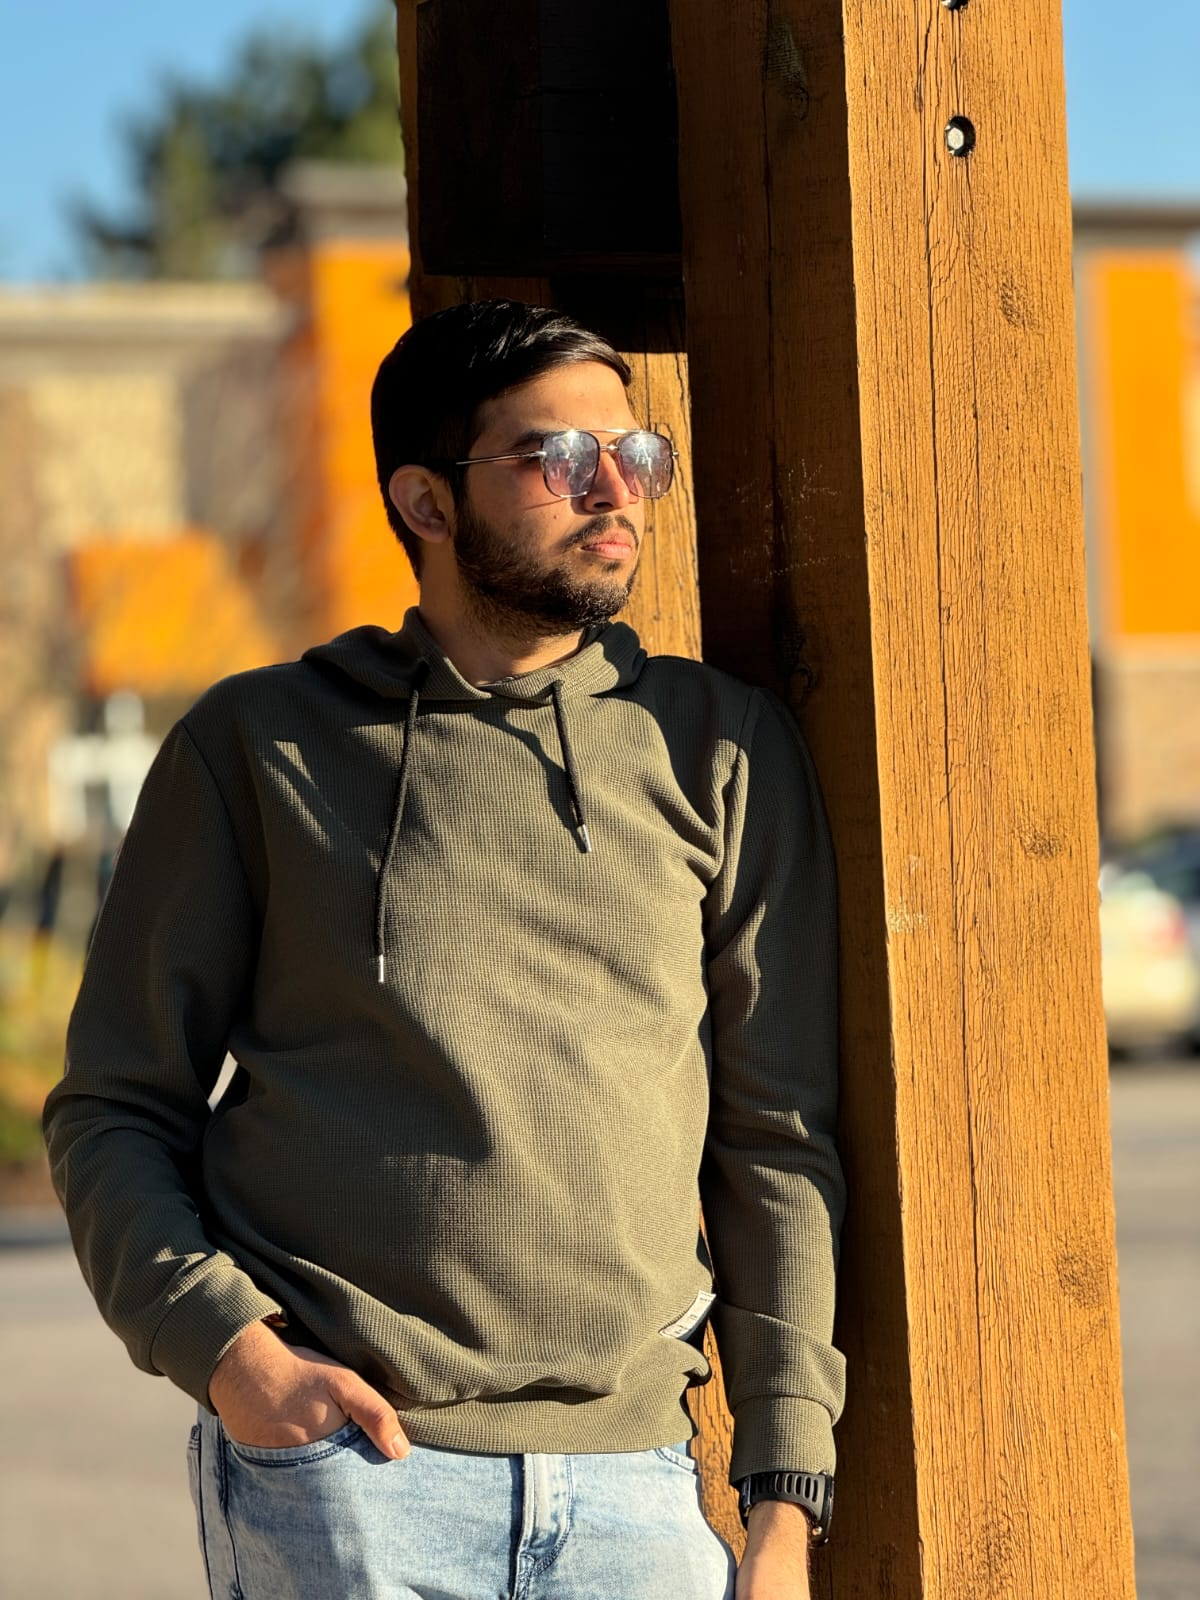

In [ ]:
img = Image.open("/content/drive/MyDrive/Module 4/Assignment/Flickr/vdp4.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print(generated_caption[:150])

<|endoftext|>A man wearing a white shirt and blue jeans is standing in front of a brick wall. A man wearing sunglasses is standing next to a building.


# **Conclusion**

As per the above trials, I can say that my model is not acting perfecltly, However, with relatively limited resources, the output seems satisfactory. Even I tried it by uploading my own image, too.